# TEST

In [ ]:
import numpy as np
from PIL import Image
from transformers import pipeline
import matplotlib.pyplot as plt
import cv2
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

def load_depth_map(file_path):
    depth_map = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    depth_map = depth_map.astype(np.float32)
    depth_map[depth_map == 0] = np.nan  # Assuming 0 indicates missing values
    return depth_map

def load_color_image(file_path):
    return cv2.imread(file_path, cv2.IMREAD_COLOR)

def get_features(z1, image, u, v):
    features = [z1[u, v], u, v, image[u, v, 0], image[u, v, 1], image[u, v, 2]]
    return features

def plot_depth_maps(depth_maps, titles, cmap='plasma', vmin=None, vmax=None):
    plt.figure(figsize=(15, 5))
    for i, depth_map in enumerate(depth_maps):
        depth_map = np.nan_to_num(depth_map, nan=-1)  # Replace NaNs for visualization
        plt.subplot(1, len(depth_maps), i + 1)
        plt.imshow(depth_map, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

def visualize_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

def neighborhood_consistency(depth_map):
    h, w = depth_map.shape
    mad = np.zeros((h, w))
    for u in range(1, h-1):
        for v in range(1, w-1):
            if not np.isnan(depth_map[u, v]):
                neighbors = [depth_map[u-1, v], depth_map[u+1, v], depth_map[u, v-1], depth_map[u, v+1]]
                neighbors = [n for n in neighbors if not np.isnan(n)]
                if neighbors:
                    mad[u, v] = np.mean([abs(depth_map[u, v] - n) for n in neighbors])
    return mad


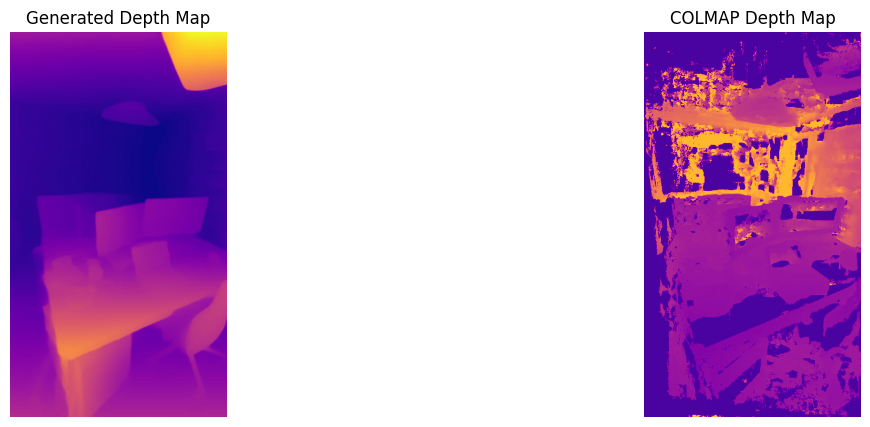

Number of NaNs in COLMAP depth map: 62


In [ ]:
# Define paths
depth_map_path = '/content/depth_map.jpeg'
colmap_depth_map_path = '/content/ethdepthmap.jpeg'
completed_depth_map_path = '/content/mlp_completed_depth_map.jpeg'
another_image_path = '/content/ethimage.jpeg'

# Load depth maps and color image
z1 = load_depth_map(depth_map_path)
z2 = load_depth_map(colmap_depth_map_path)
image = load_color_image(another_image_path)

# Display the images
plot_depth_maps([z1, z2], ["Generated Depth Map", "COLMAP Depth Map"])

# Check for NaNs in z2
nan_count = np.isnan(z2).sum()
print(f"Number of NaNs in COLMAP depth map: {nan_count}")


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1, loss = 3768.88263940
Iteration 2, loss = 3761.48230500
Iteration 3, loss = 3754.21253995
Iteration 4, loss = 3747.07142278
Iteration 5, loss = 3739.97772057
Iteration 6, loss = 3732.85888346
Iteration 7, loss = 3725.63607847
Iteration 8, loss = 3718.29674682
Iteration 9, loss = 3710.70085858
Iteration 10, loss = 3702.78168960
Iteration 11, loss = 3694.73766858
Iteration 12, loss = 3686.52627045
Iteration 13, loss = 3678.08016588
Iteration 14, loss = 3669.42844792
Iteration 15, loss = 3660.56095519
Iteration 16, loss = 3651.48928480
Iteration 17, loss = 3642.23671382
Iteration 18, loss = 3632.83208971
Iteration 19, loss = 3623.14240921
Iteration 20, loss = 3613.14138007
Iteration 21, loss = 3602.86244659
Iteration 22, loss = 3592.28670386
Iteration 23, loss = 3581.35744620
Iteration 24, loss = 3570.12402504
Iteration 25, loss = 3558.54529824
Iteration 26, loss = 3546.63083040
Iteration 27, loss = 3534.37969073
Iteration 28, loss = 3521.83634162
Iteration 29, loss = 3508.925

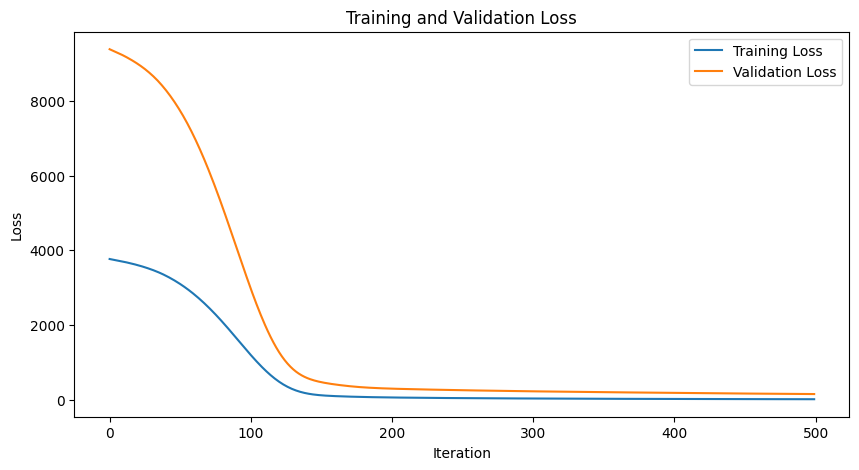

In [ ]:
# Create dataset focusing on pixels where COLMAP depth map is NaN
data = []
labels = []

# If there are no NaNs, use all pixels
if nan_count == 0:
    for u in range(z1.shape[0]):
        for v in range(z1.shape[1]):
            features = get_features(z1, image, u, v)
            data.append(features)
            labels.append(z2[u, v])  # Use COLMAP depth as the label
else:
    for u in range(z1.shape[0]):
        for v in range(z1.shape[1]):
            if np.isnan(z2[u, v]):
                features = get_features(z1, image, u, v)
                data.append(features)
                labels.append(z1[u, v])  # Use monocular depth as the label

data = np.array(data)
labels = np.array(labels)

# Remove rows with NaNs from the dataset
mask = ~np.isnan(data).any(axis=1)
data = data[mask]
labels = labels[mask]

# Ensure data is not empty
if data.shape[0] == 0:
    raise ValueError("No data points found. Ensure the COLMAP depth map contains NaNs or use a different approach.")

# Scale the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

class MLPRegressorWithProgress(MLPRegressor):
    def fit(self, X, y):
        self.max_iter = self.max_iter or 200
        self._fit_stages = np.array_split(range(self.max_iter), 500)
        self.train_losses = []
        self.val_losses = []
        with tqdm(total=self.max_iter, desc="Training Progress") as pbar:
            for stages in self._fit_stages:
                super().partial_fit(X, y)
                pbar.update(len(stages))
                self.train_losses.append(self.loss_)
                val_pred = self.predict(val_data)
                val_loss = mean_squared_error(val_labels, val_pred)
                self.val_losses.append(val_loss)
        return self

# Train the MLP regressor
mlp_regressor = MLPRegressorWithProgress(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, verbose=True)
mlp_regressor.fit(train_data, train_labels)
train_losses = mlp_regressor.train_losses
val_losses = mlp_regressor.val_losses

# Visualize training and validation losses
visualize_losses(train_losses, val_losses)


In [ ]:
# Function to predict depth for a given pixel
def predict_depth(mlp_regressor, scaler, z1, image, u, v):
    features = get_features(z1, image, u, v)
    features = np.array(features).reshape(1, -1)
    features = np.nan_to_num(features, nan=0)  # Replace NaNs with zero
    features = scaler.transform(features)
    depth = mlp_regressor.predict(features)[0]
    return depth

# Improve the COLMAP depth map
improved_z2 = np.copy(z2)
for u in range(z2.shape[0]):
    for v in range(z2.shape[1]):
        if np.isnan(z2[u, v]):  # Only improve NaNs
            improved_z2[u, v] = predict_depth(mlp_regressor, scaler, z1, image, u, v)

# Save the improved depth map
cv2.imwrite('/content/improved_colmap_depth_map.jpeg', improved_z2)
print("Improved COLMAP depth map saved as '/content/improved_colmap_depth_map.jpeg'.")


Improved COLMAP depth map saved as '/content/improved_colmap_depth_map.jpeg'.


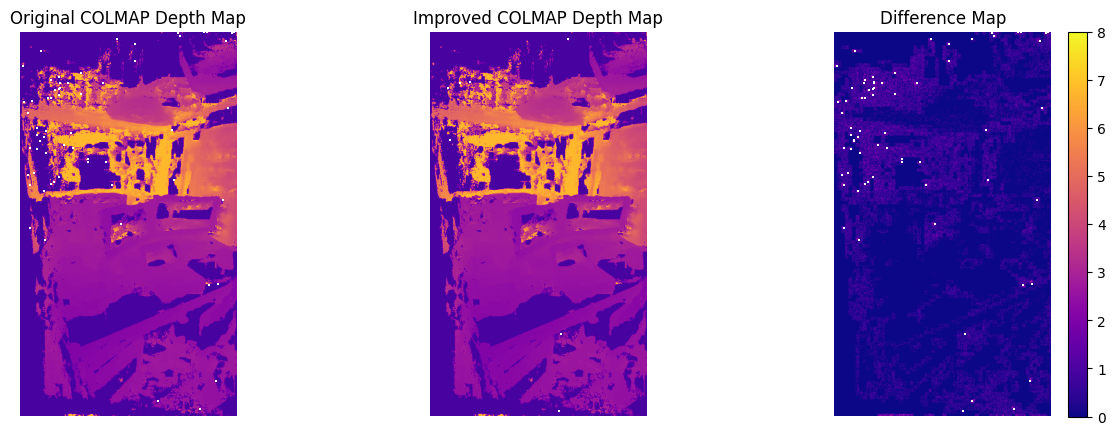

In [ ]:
# Load the improved depth map
improved_colmap_depth_map_path = "/content/improved_colmap_depth_map.jpeg"
improved_colmap_depth_map = load_depth_map(improved_colmap_depth_map_path)

# Display the improved depth map
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(z2, cmap='plasma')
plt.title("Original COLMAP Depth Map")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(improved_colmap_depth_map, cmap='plasma')
plt.title("Improved COLMAP Depth Map")
plt.axis("off")

# Display the difference map
difference_map = np.abs(z2 - improved_colmap_depth_map)
plt.subplot(1, 3, 3)
plt.imshow(difference_map, cmap='plasma')
plt.title("Difference Map")
plt.colorbar()
plt.axis("off")

plt.show()


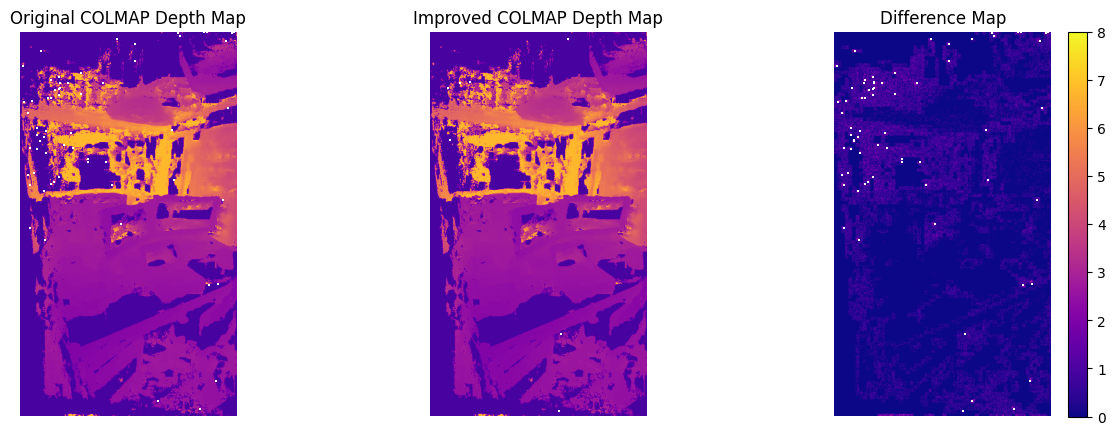

In [ ]:
# Load the improved depth map
improved_colmap_depth_map_path = "/content/improved_colmap_depth_map.jpeg"
improved_colmap_depth_map = load_depth_map(improved_colmap_depth_map_path)

# Display the improved depth map
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(z2, cmap='plasma')
plt.title("Original COLMAP Depth Map")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(improved_colmap_depth_map, cmap='plasma')
plt.title("Improved COLMAP Depth Map")
plt.axis("off")

# Display the difference map
difference_map = np.abs(z2 - improved_colmap_depth_map)
plt.subplot(1, 3, 3)
plt.imshow(difference_map, cmap='plasma')
plt.title("Difference Map")
plt.colorbar()
plt.axis("off")

plt.show()


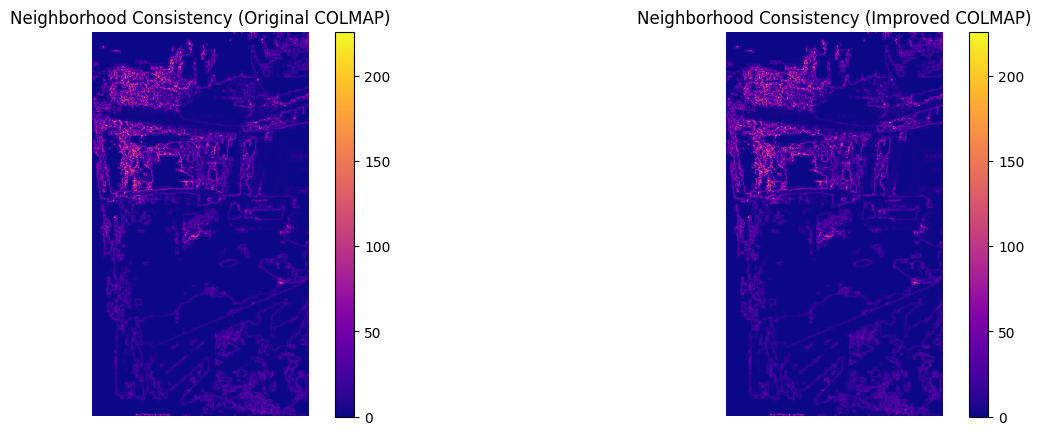

Mean Neighborhood Consistency (Original COLMAP): 9.5922
Mean Neighborhood Consistency (Improved COLMAP): 9.6067


In [ ]:
# Compute neighborhood consistency for the original and improved depth maps
mad_original = neighborhood_consistency(z2)
mad_improved = neighborhood_consistency(improved_z2)

# Display the neighborhood consistency maps
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(mad_original, cmap='plasma')
plt.title("Neighborhood Consistency (Original COLMAP)")
plt.colorbar()
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mad_improved, cmap='plasma')
plt.title("Neighborhood Consistency (Improved COLMAP)")
plt.colorbar()
plt.axis("off")

plt.show()

# Compare the mean neighborhood consistency
mean_mad_original = np.nanmean(mad_original)
mean_mad_improved = np.nanmean(mad_improved)

print(f"Mean Neighborhood Consistency (Original COLMAP): {mean_mad_original:.4f}")
print(f"Mean Neighborhood Consistency (Improved COLMAP): {mean_mad_improved:.4f}")


Combined depth map with cross-validation saved as '/content/combined_depth_map_crossval.jpeg'.


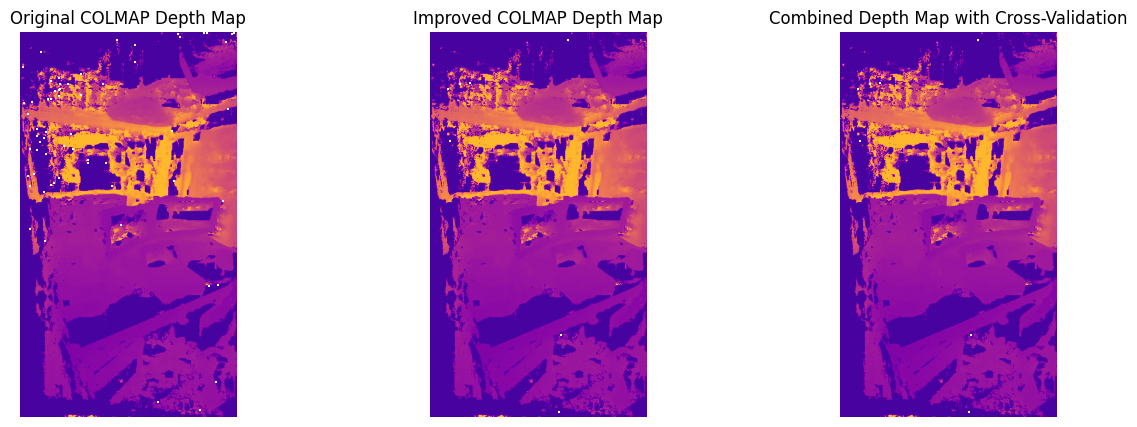

In [ ]:
# Combine the depth maps by retaining original values where COLMAP depth is valid
combined_depth_map = np.copy(z2)
nan_mask = np.isnan(z2)
combined_depth_map[nan_mask] = improved_z2[nan_mask]

# Save the combined depth map
cv2.imwrite('/content/combined_depth_map_crossval.jpeg', combined_depth_map)
print("Combined depth map with cross-validation saved as '/content/combined_depth_map_crossval.jpeg'.")

# Load and visualize the combined depth map
combined_depth_map_path = '/content/combined_depth_map_crossval.jpeg'
combined_depth_map = load_depth_map(combined_depth_map_path)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(z2, cmap='plasma')
plt.title("Original COLMAP Depth Map")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(improved_colmap_depth_map, cmap='plasma')
plt.title("Improved COLMAP Depth Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(combined_depth_map, cmap='plasma')
plt.title("Combined Depth Map with Cross-Validation")
plt.axis("off")

plt.show()


In [43]:
# Ensure no NaNs in z1
z1 = np.nan_to_num(z1, nan=0)

# Ensure no NaNs in image
image[np.isnan(image)] = 0

In [44]:
# Create dataset focusing on pixels where COLMAP depth map is not NaN
data = []
labels = []

for u in range(z1.shape[0]):
    for v in range(z1.shape[1]):
        if not np.isnan(z2_removed[u, v]):
            features = [z1[u, v], u, v, image[u, v, 0], image[u, v, 1], image[u, v, 2]]
            data.append(features)
            labels.append(z2[u, v])  # Use original COLMAP depth as the label

data = np.array(data)
labels = np.array(labels)

# Remove rows with NaNs from the dataset
nan_mask = ~np.isnan(data).any(axis=1)
data = data[nan_mask]
labels = labels[nan_mask]

# Ensure data is not empty and lengths are consistent
if data.shape[0] == 0:
    raise ValueError("No data points found. Ensure the COLMAP depth map contains NaNs or use a different approach.")

if data.shape[0] != labels.shape[0]:
    raise ValueError(f"Data and labels have inconsistent lengths: {data.shape[0]} vs {labels.shape[0]}")

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Scale the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the MLP regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, verbose=True)
mlp_regressor.fit(train_data, train_labels)

Iteration 1, loss = 1263.16436379
Iteration 2, loss = 834.98200900
Iteration 3, loss = 804.30309090
Iteration 4, loss = 790.18692782
Iteration 5, loss = 780.21938246
Iteration 6, loss = 772.61410834
Iteration 7, loss = 765.67105649
Iteration 8, loss = 759.73027766
Iteration 9, loss = 753.85648168
Iteration 10, loss = 749.65947166
Iteration 11, loss = 744.67834962
Iteration 12, loss = 740.29145318
Iteration 13, loss = 735.22587749
Iteration 14, loss = 730.47457587
Iteration 15, loss = 725.77700429
Iteration 16, loss = 720.79514970
Iteration 17, loss = 716.82024036
Iteration 18, loss = 713.51301011
Iteration 19, loss = 710.37797459
Iteration 20, loss = 706.24017790
Iteration 21, loss = 702.06151317
Iteration 22, loss = 698.15013718
Iteration 23, loss = 695.09088728
Iteration 24, loss = 691.04132876
Iteration 25, loss = 687.62390938
Iteration 26, loss = 683.80344427
Iteration 27, loss = 680.23872955
Iteration 28, loss = 676.67843475
Iteration 29, loss = 673.65217362
Iteration 30, loss = 6

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42,
             verbose=True)

In [47]:
# Function to predict depth using the trained MLP regressor
def predict_depth(mlp_regressor, scaler, z1, image, u, v):
    features = [z1[u, v], u, v, image[u, v, 0], image[u, v, 1], image[u, v, 2]]
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    depth = mlp_regressor.predict(features)[0]
    return depth

# Estimate the removed values
estimated_values = []
for idx in remove_indices:
    u, v = idx
    estimated_value = predict_depth(mlp_regressor, scaler, z1, image, u, v)
    estimated_values.append(estimated_value)

estimated_values = np.array(estimated_values)

# Evaluate the estimation
mse_estimation = mean_squared_error(original_values, estimated_values)
mae_estimation = mean_absolute_error(original_values, estimated_values)

print(f"MSE for estimated values: {mse_estimation:.4f}")
print(f"MAE for estimated values: {mae_estimation:.4f}")

MSE for estimated values: 988.5062
MAE for estimated values: 19.2427
